# Number/Digit identification using Keras via Tensorflow and the MNIST dataset

In [1]:
# We would be using keras via the tensorflow library
# Importing the necesary modules
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

### Loading the MNIST dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Viewing the shapes of the training data.

In [3]:
print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of test_images: {test_images.shape}")
print(f"Shape of test_labels: {test_labels.shape}")

Shape of train_images: (60000, 28, 28)
Shape of train_labels: (60000,)
Shape of test_images: (10000, 28, 28)
Shape of test_labels: (10000,)


### Visualizing the images in the dataset

We make use of matplolib pyplot

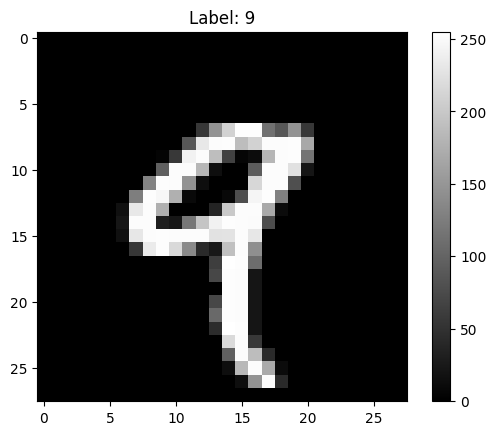

In [4]:
plt.imshow(train_images[4], cmap='gray')
plt.title(f"Label: {train_labels[4]}")
plt.colorbar() # Adds a color bar to show pixel intensity scale
plt.show()

### Normalize Pixel Values

The pixel values in the MNIST images range from 0 to 255 (where 0 is black and 255 is white). Neural networks generally perform better when input values are scaled to a smaller range, such as 0 to 1 or -1 to 1. We'll normalize them to the range [0, 1].

* `train_images.astype('float32')`: We cast the data type of the image arrays to `float32`. Neural networks typically work with floating-point numbers for calculations. Original data is often `uint8` (unsigned 8-bit integers).
* `/ 255.0`: We divide every pixel value by 255.0. Since the maximum pixel value is 255, this scales all pixel values to be between 0.0 (for black) and 1.0 (for white). This normalization helps the neural network converge faster and perform better.

In [5]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

#### Reshape Images for the Model

For our first model, we'll use a simple "Dense" (fully connected) neural network. These networks expect a 1D array (vector) as input for each sample, not a 2D image. So, we need to "flatten" each 28x28 image into a 784-element vector (28 * 28 = 784).

In [6]:
train_images_flat = train_images.reshape((60000, 28 * 28))
test_images_flat = test_images.reshape((10000, 28 * 28))

print("Shape of flattened train_images:", train_images_flat.shape)
print("Shape of flattened test_images:", test_images_flat.shape)

Shape of flattened train_images: (60000, 784)
Shape of flattened test_images: (10000, 784)


### One-Hot Encode Labels

Our target labels (0-9) are single integers. For multi-class classification problems, especially when using a `softmax` activation in the output layer (which we will), it's best practice to convert these integer labels into a "one-hot encoded" format.

One-hot encoding converts a single integer label into a binary vector where only one element is "hot" (1) and the rest are "cold" (0).
For example:
* Digit `0` becomes `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* Digit `1` becomes `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* Digit `9` becomes `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

Since we have 10 possible digits (0-9), each label will be converted into a 10-element vector.

In [7]:
# Optional, to_categorical infers the value from the dataset.
num_classes = 10

train_labels_one_hot = to_categorical(train_labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

print("Shape of one-hot encoded train_labels:", train_labels_one_hot.shape)
print("First 5 one-hot encoded train_labels:\n", train_labels_one_hot[:5])
print("Original first 5 train_labels:", train_labels[:5])

Shape of one-hot encoded train_labels: (60000, 10)
First 5 one-hot encoded train_labels:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Original first 5 train_labels: [5 0 4 1 9]


### Building the Neural Network Model

Now we define our neural network architecture using Keras's `Sequential` API. A `Sequential` model is a linear stack of layers.

In [8]:
# Create a Sequential model
# Sequential models are a linear stack of layers.
model = models.Sequential()

# --- Recommended way to define the input shape in Sequential models ---
# Input layer
# This layer's sole purpose is to explicitly define the shape of the input data
# that the model expects.
# It makes the model definition clearer and aligns with Keras best practices.
# For a 28x28 pixel image flattened, the shape is (784,).
model.add(Input(shape=(784, )))

# First Hidden Layer
# A Dense layer is a regular deeply connected neural network layer.
# It has 512 units (neurons).
# 'relu' (Rectified Linear Unit) is a common activation function,
# which helps the model learn non-linear relationships.
# We no longer need 'input_shape' here, as it's handled by the preceding Input layer.
model.add(layers.Dense(512, activation='relu'))

# Dropout layer
# Dropout is a regularization technique that randomly sets a fraction of input units to 0
# at each update during training time. This helps prevent overfitting by
# making neurons less dependent on specific other neurons.
# Here, 60% (0.6) of the neurons' outputs will be randomly "dropped out" (set to zero)
# during each training step.
model.add(layers.Dropout(0.6))

# Second Hidden Layer
# Another Dense layer with 512 units and 'relu' activation.
# Keras automatically infers the input shape from the previous layer,
# so we don't need to specify it again. This is standard for subsequent layers.
model.add(layers.Dense(512, activation='relu'))

# Another Dropout layer
# Applying dropout again after the second hidden layer.
model.add(layers.Dropout(0.6))

# Output Layer
# This layer has 'num_classes' units (e.g., 10 for digits 0-9).
# 'softmax' activation function is used for multi-class classification.
# It converts the raw outputs (logits) into a probability distribution over the
# 'num_classes' classes, meaning the sum of its outputs is 1.
# The class with the highest probability is the model's prediction.
model.add(layers.Dense(num_classes, activation='softmax'))

# It's useful to see a summary of the model we just built.
# This prints a table summarizing the layers, their output shapes, and the number
# of trainable parameters.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

Before training, we need to configure the model's learning process. This is done in the `compile` step.

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model)

<Sequential name=sequential, built=True>


### Train the Model (Fit the Model)

Now that the model is built and compiled, we can train it using our preprocessed training data. This process is often called "fitting" the model to the data.

In [10]:
epochs = 18 # Number of times to iterate over the entire training dataset
batch_size = 108 # Number of samples per gradient update

history = model.fit(train_images_flat, train_labels_one_hot,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.3) # Use 30% of training data for validation

Epoch 1/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7413 - loss: 0.8015 - val_accuracy: 0.9484 - val_loss: 0.1734
Epoch 2/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9279 - loss: 0.2374 - val_accuracy: 0.9594 - val_loss: 0.1365
Epoch 3/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.9475 - loss: 0.1768 - val_accuracy: 0.9666 - val_loss: 0.1149
Epoch 4/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9523 - loss: 0.1557 - val_accuracy: 0.9703 - val_loss: 0.1036
Epoch 5/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9582 - loss: 0.1395 - val_accuracy: 0.9696 - val_loss: 0.1017
Epoch 6/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9620 - loss: 0.1189 - val_accuracy: 0.9721 - val_loss: 0.0932
Epoch 7/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9622 - loss: 0.1186 - val_accuracy: 0.9723 - val_loss: 0.0946
Epoch 8/18
389/389 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9674 - loss: 0.1048 - val_ac

### Evaluate the Model

After training, we want to see how well our model performs on completely unseen data – the test set.

In [14]:
test_loss, test_accuracy = model.evaluate(test_images_flat, test_labels_one_hot, verbose=1)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9758 - loss: 0.0857

Test Loss: 0.0724
Test Accuracy: 0.9788


### Make Predictions

Finally, let's use our trained model to make predictions on some individual images from the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Predictions for the first 5 test images:
Image 1:
  Predicted Probabilities: [1.2325066e-11 7.3134632e-10 6.6530873e-08 9.7595921e-07 8.0107443e-13
 2.3635122e-10 3.7432262e-17 9.9999875e-01 5.0537569e-10 1.5331030e-07]
  Predicted Digit: 7
  True Digit: 7
------------------------------
Image 2:
  Predicted Probabilities: [1.3540305e-14 1.6950423e-08 9.9999994e-01 2.5764444e-09 3.5746097e-17
 2.1988316e-14 4.0238321e-15 7.5474314e-12 2.0379856e-11 8.6995361e-21]
  Predicted Digit: 2
  True Digit: 2
------------------------------
Image 3:
  Predicted Probabilities: [9.7815156e-10 9.9998957e-01 1.3036531e-07 7.6972617e-10 1.0439519e-06
 1.6560524e-09 4.5766022e-08 9.0546928e-06 1.1572472e-07 2.0201949e-09]
  Predicted Digit: 1
  True Digit: 1
------------------------------
Image 4:
  Predicted Probabilities: [9.99941528e-01 1.06386656e-10 9.76983117e-08 2.86376665e-08
 3.56509444e-09 1.41324037e-07 5.76900529e-05 3.27855609e-08
 1.07206388e-09 4.045

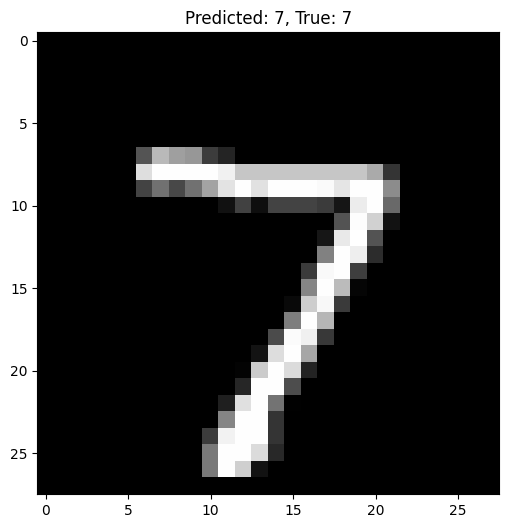

In [12]:
# Select a few images from the test set for prediction
num_predictions = 21
sample_images = test_images_flat[:num_predictions]
true_labels = test_labels[:num_predictions]

# Make predictions
predictions = model.predict(sample_images)

print("\nPredictions for the first 5 test images:")
for i in range(num_predictions):
    predicted_probabilities = predictions[i]
    predicted_class = np.argmax(predicted_probabilities) # Get the index of the highest probability
    print(f"Image {i+1}:")
    print(f"  Predicted Probabilities: {predicted_probabilities}")
    print(f"  Predicted Digit: {predicted_class}")
    print(f"  True Digit: {true_labels[i]}")
    print("-" * 30)

# Visualize one of the predictions
plt.figure(figsize=(6, 6))
plt.imshow(test_images[0], cmap='gray') # Use original 2D image for visualization
plt.title(f"Predicted: {np.argmax(predictions[0])}, True: {test_labels[0]}")
plt.show()

### Plot Training History (Optional but Recommended)

Visualizing the training history (loss and accuracy over epochs) is incredibly helpful for understanding how your model learned and for detecting issues like overfitting.

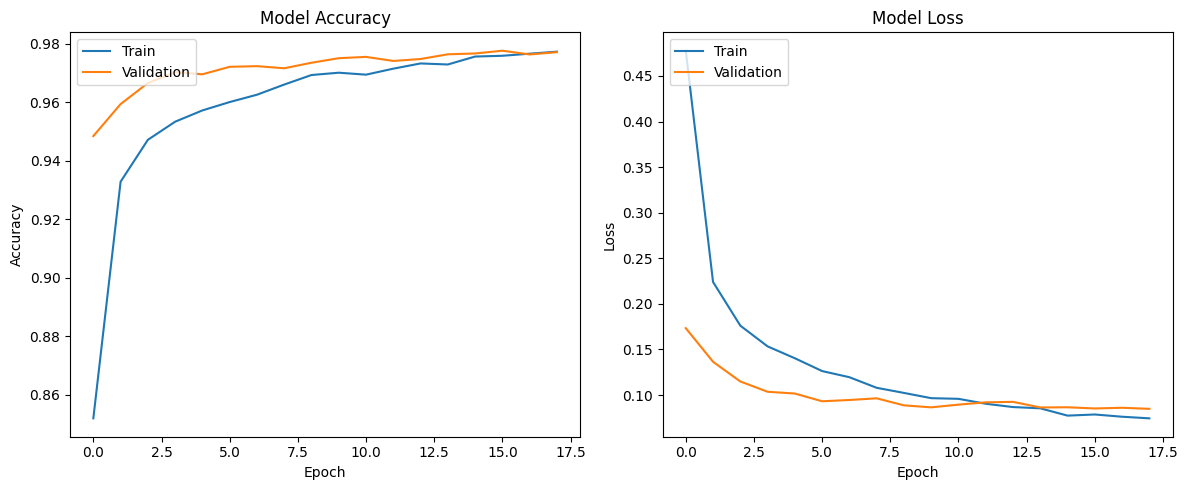

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout() # Adjusts plot parameters for a tight layout
plt.show()